In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mne
import dynsys_orig as dynsys
from scipy.integrate import solve_ivp
import numpy as np
import matplotlib.pyplot as plt
import PRA as pra
from mne_connectivity import spectral_connectivity_epochs
from spectral_connectivity import Multitaper, Connectivity
np.random.seed(42)  # For reproducibility

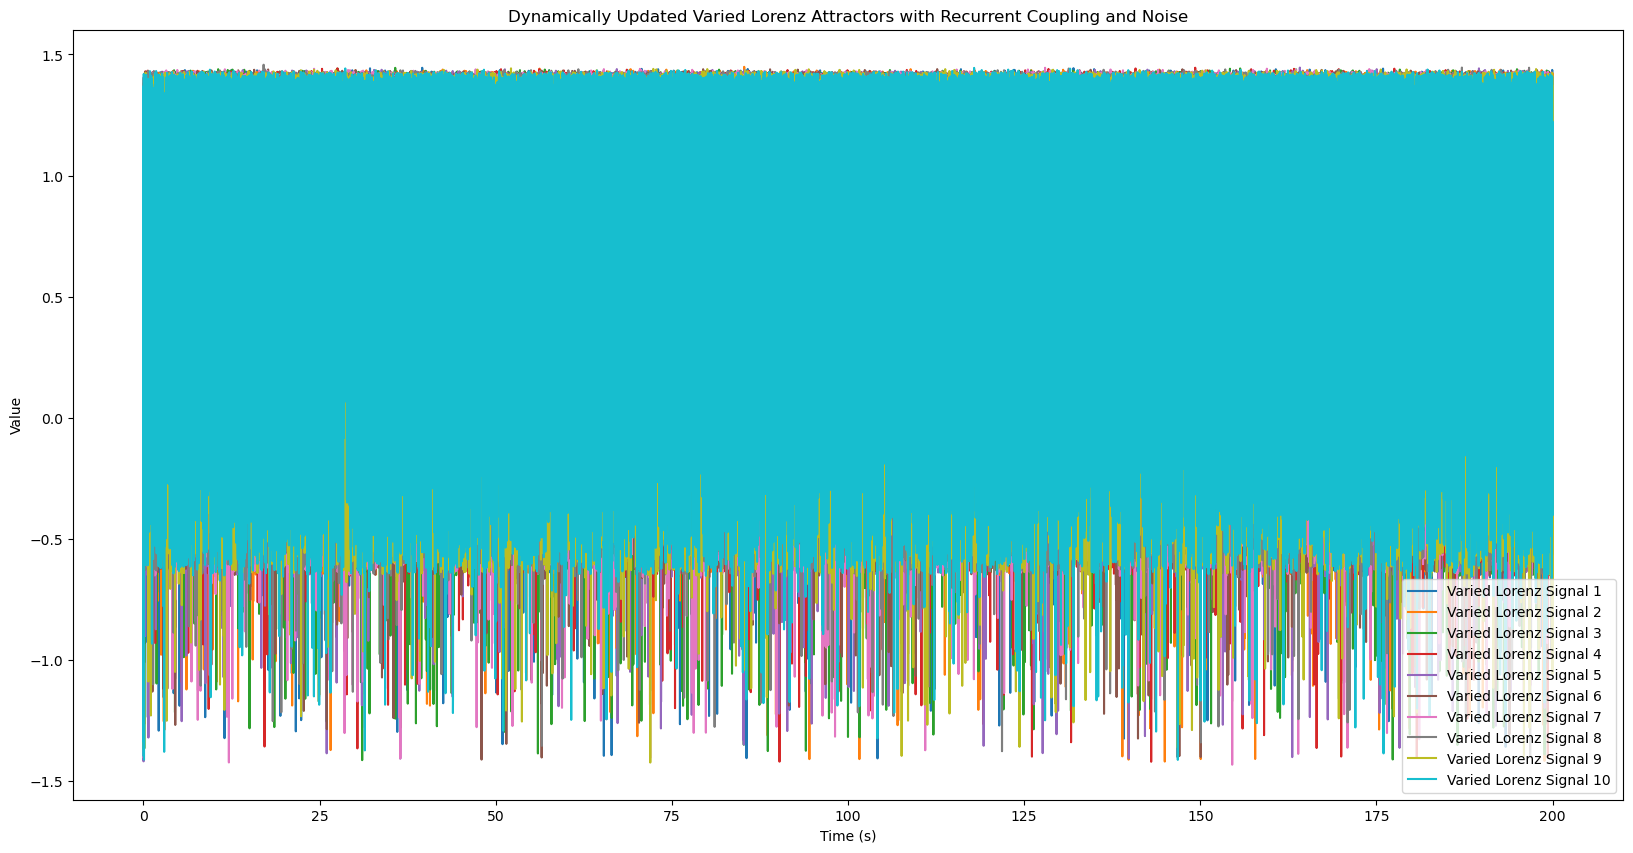

Adjacency Matrix:
[[0 0 0 0 0 0 0 0 1 1]
 [1 0 0 0 0 0 0 0 0 1]
 [1 1 0 0 0 0 0 0 0 0]
 [0 1 1 0 0 0 0 0 0 0]
 [0 0 1 1 0 0 0 0 0 0]
 [0 0 0 1 1 0 0 0 0 0]
 [0 0 0 0 1 1 0 0 0 0]
 [0 0 0 0 0 1 1 0 0 0]
 [0 0 0 0 0 0 1 1 0 0]
 [0 0 0 0 0 0 0 1 1 0]]


In [2]:
"""#parameters
sampling_rate = 100  # Hz
duration = 200  # seconds
n_points = sampling_rate * duration
time = np.linspace(0, duration, n_points)

# Lorenz system parameters for 10 systems with slight variations
parameters = np.array([
    [10.0, 28.0, 8/3],  # Classic parameters
    [10.1, 29.0, 8/3.1],
    [9.9, 31.0, 8/3.2],
    [10.2, 32.0, 8/3.3],
    [9.8, 30.0, 8/3.4],
    [10.3, 33.0, 8/3.5],
    [9.7, 34.0, 8/3.6],
    [10.4, 35.0, 8/3.7],
    [9.6, 36.0, 8/3.8],
    [10.5, 37.0, 8/3.9]
])

# Function to compute the derivatives of the Lorenz system
def lorenz_system(t, state, sigma, rho, beta):
    x, y, z = state
    dxdt = sigma * (y - x)
    dydt = x * (rho - z) - y
    dzdt = x * y - beta * z
    return [dxdt, dydt, dzdt]

# Time vector for integration
t_span = [0, duration]
t_eval = np.linspace(0, duration, n_points)

# Integrate the Lorenz system for each set of parameters
lorenz_signals_varied = np.empty((10, n_points))
for i, (sigma, rho, beta) in enumerate(parameters):
    initial_condition = np.random.rand(3) * 0.1 + np.array([10, 10, 20])
    sol = solve_ivp(lorenz_system, t_span, initial_condition, args=(sigma, rho, beta), t_eval=t_eval)
    lorenz_signals_varied[i] = np.sin(sol.y[0]+sol.y[1]+sol.y[2]) + np.cos(sol.y[0]+sol.y[1]+sol.y[2])  # Merging the 3 signals

# Coupling parameters
coupling_strength = 1.0  # Uniform coupling strength
lag = 2  # Uniform lag
noise_level = 0.01  # Noise level

# Adjacency matrix initialization
adjacency_matrix = np.zeros((10, 10), dtype=int)
for i in range(10):
    influenced_signals = [(i + 1) % 10, (i + 2) % 10]
    for j in influenced_signals:
        adjacency_matrix[j, i] = 1

# Apply coupling and noise to the Lorenz signals
coupled_lorenz_signals_varied = lorenz_signals_varied.copy()
for t in range(lag, n_points):
    for i in range(10):
        influenced_signals = [(i + 1) % 10, (i + 2) % 10]
        for j in influenced_signals:
            coupled_lorenz_signals_varied[j, t] += coupling_strength * coupled_lorenz_signals_varied[i, t - lag]
            coupled_lorenz_signals_varied[j, t] = np.sin(coupled_lorenz_signals_varied[j, t]) + np.cos(coupled_lorenz_signals_varied[j, t])  # Nonlinearity

# Add noise after dynamic updating
coupled_lorenz_signals_varied += noise_level * np.random.randn(*coupled_lorenz_signals_varied.shape)

# Plotting the signals
plt.figure(figsize=(20, 10))
for i in range(10):
    plt.plot(time, coupled_lorenz_signals_varied[i], label=f'Varied Lorenz Signal {i+1}')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Value')
plt.title('Dynamically Updated Varied Lorenz Attractors with Recurrent Coupling and Noise')
plt.show()

# Print the adjacency matrix
print("Adjacency Matrix:")
print(adjacency_matrix)"""


In [3]:
# Parameters
sampling_rate = 100  # Hz
duration = 200 # seconds
n_points = sampling_rate * duration
time = np.linspace(0, duration, n_points)

# Generate 10 base sine waves with distinct frequencies
frequencies = np.linspace(8.7, 12.4, 10)  # From 8.7 Hz to 12.4 Hz in 10 steps
signals = np.sin(2 * np.pi * np.outer(frequencies, time))

# Coupling parameters
coupling_strength = 1.0  # Uniform coupling strength
lag = 2  # Uniform lag
noise_level = 0.1  # Noise level

# Adjacency matrix initialization
adjacency_matrix = np.zeros((10, 10), dtype=int)

# Define coupling connections and apply dynamic updating with tanh activation
for i in range(10):
    influenced_signals = [(i + 1) % 10, (i + 2) % 10]  # Signals influenced by signal i
    for j in influenced_signals:
        adjacency_matrix[j, i] = 1  # Update adjacency matrix

# Dynamic updating with coupling and tanh activation
for t in range(lag, n_points):
    for i in range(10):
        influenced_signals = [(i + 1) % 10, (i + 2) % 10]  # Signals influenced by signal i
        for j in influenced_signals:
            signals[j, t] -= coupling_strength * signals[i, t - lag]
            # Apply non linear activation to limit the signal values and model neural dynamics
            signals[j, t] = np.sin(signals[j, t])

# Add noise after dynamic updating
signals += noise_level * np.random.randn(*signals.shape)

# Plotting the signals
plt.figure(figsize=(20, 10))
for i in range(10):
    plt.plot(time, signals[i], label=f'Signal {i+1}')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Value')
plt.title('Dynamically Updated Sinusoidal Time Series with Recurrent Coupling, Noise, and Tanh Activation')
plt.show()

# Display the adjacency matrix
print("Adjacency Matrix:")
print(adjacency_matrix)


'# Parameters\nsampling_rate = 100  # Hz\nduration = 200 # seconds\nn_points = sampling_rate * duration\ntime = np.linspace(0, duration, n_points)\n\n# Generate 10 base sine waves with distinct frequencies\nfrequencies = np.linspace(8.7, 12.4, 10)  # From 8.7 Hz to 12.4 Hz in 10 steps\nsignals = np.sin(2 * np.pi * np.outer(frequencies, time))\n\n# Coupling parameters\ncoupling_strength = 1.0  # Uniform coupling strength\nlag = 2  # Uniform lag\nnoise_level = 0.1  # Noise level\n\n# Adjacency matrix initialization\nadjacency_matrix = np.zeros((10, 10), dtype=int)\n\n# Define coupling connections and apply dynamic updating with tanh activation\nfor i in range(10):\n    influenced_signals = [(i + 1) % 10, (i + 2) % 10]  # Signals influenced by signal i\n    for j in influenced_signals:\n        adjacency_matrix[j, i] = 1  # Update adjacency matrix\n\n# Dynamic updating with coupling and tanh activation\nfor t in range(lag, n_points):\n    for i in range(10):\n        influenced_signals = 

In [4]:
## simulated data
#sim_data = np.array([A,B,C])
ch_names=["A", "B", "C","D","E","F","G","H","I","J"]
#ch_names = ["A", "B", "C"]
sim_data = np.array(signals)
info = mne.create_info(ch_names=ch_names, ch_types=["eeg"]*10, sfreq=100)
simulated_raw = mne.io.RawArray(sim_data, info)
epochs = mne.make_fixed_length_epochs(simulated_raw, duration=20)

Creating RawArray with float64 data, n_channels=10, n_times=20000
    Range : 0 ... 19999 =      0.000 ...   199.990 secs
Ready.
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated


In [5]:
## estimations
#dynsys
epoch_idx = np.arange(1)
region = ['A','B','C']
dynsys_mat,cond_num,mse,snr = dynsys.dynSys(epochs.get_data(), epoch_idx, region, sampling_time=0.01)

#PRA
pra_mat = pra.PRA(epochs.get_data())


#coh 
mne_con = spectral_connectivity_epochs(epochs, method='coh', sfreq=sampling_rate, fmin=8, fmax=13, fskip=0, faverage=False,
                                      mt_low_bias=True, block_size=1000, n_jobs=1, verbose=None)
coh_mat = mne_con.get_data(output="dense")

#ciplv
mne_con = spectral_connectivity_epochs(epochs, method='ciplv', sfreq=sampling_rate, fmin=8, fmax=13, fskip=0, faverage=False,
                                      mt_low_bias=True, block_size=1000, n_jobs=1, verbose=None)
ciplv_mat = mne_con.get_data(output="dense")

#gpdc
m = Multitaper(time_series=np.array(epochs.get_data()).transpose(2, 0, 1), sampling_frequency=100)
c = Connectivity(fourier_coefficients=m.fft(), frequencies=m.frequencies, time=m.time)    
con = getattr(c, 'generalized_partial_directed_coherence')()
gpdc_mat = np.nan_to_num(con.squeeze())[80:131].transpose(1,2,0)

#ddtf
m = Multitaper(time_series=np.array(epochs.get_data()).transpose(2, 0, 1), sampling_frequency=100)
c = Connectivity(fourier_coefficients=m.fft(), frequencies=m.frequencies, time=m.time)    
con = getattr(c, 'direct_directed_transfer_function')()
ddtf_mat = np.nan_to_num(con.squeeze())[80:131].transpose(1,2,0)

#psgp
m = Multitaper(time_series=np.array(epochs.get_data()).transpose(2, 0, 1), sampling_frequency=100)
c = Connectivity(fourier_coefficients=m.fft(), frequencies=m.frequencies, time=m.time)    
con = getattr(c, 'pairwise_spectral_granger_prediction')()
psgp_mat = np.nan_to_num(con.squeeze())[80:131].transpose(1,2,0)

Using data from preloaded Raw for 10 events and 2000 original time points ...
0 bad epochs dropped


  0%|          | 0/10 [00:00<?, ?it/s]

Using data from preloaded Raw for 10 events and 2000 original time points ...


  0%|          | 0/10 [00:00<?, ?it/s]

Adding metadata with 3 columns
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 45 connections
    using t=0.000s..19.990s for estimation (2000 points)
    frequencies: 8.0Hz..13.0Hz (101 points)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherence
    computing connectivity for epoch 1
    computing connectivity for epoch 2
    computing connectivity for epoch 3
    computing connectivity for epoch 4
    computing connectivity for epoch 5
    computing connectivity for epoch 6
    computing connectivity for epoch 7
    computing connectivity for epoch 8
    computing connectivity for epoch 9
    computing connectivity for epoch 10
    assembling connectivity matrix
[Connectivity computation done]
Replacing existing metadata with 3 columns
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 45 connections
    using 

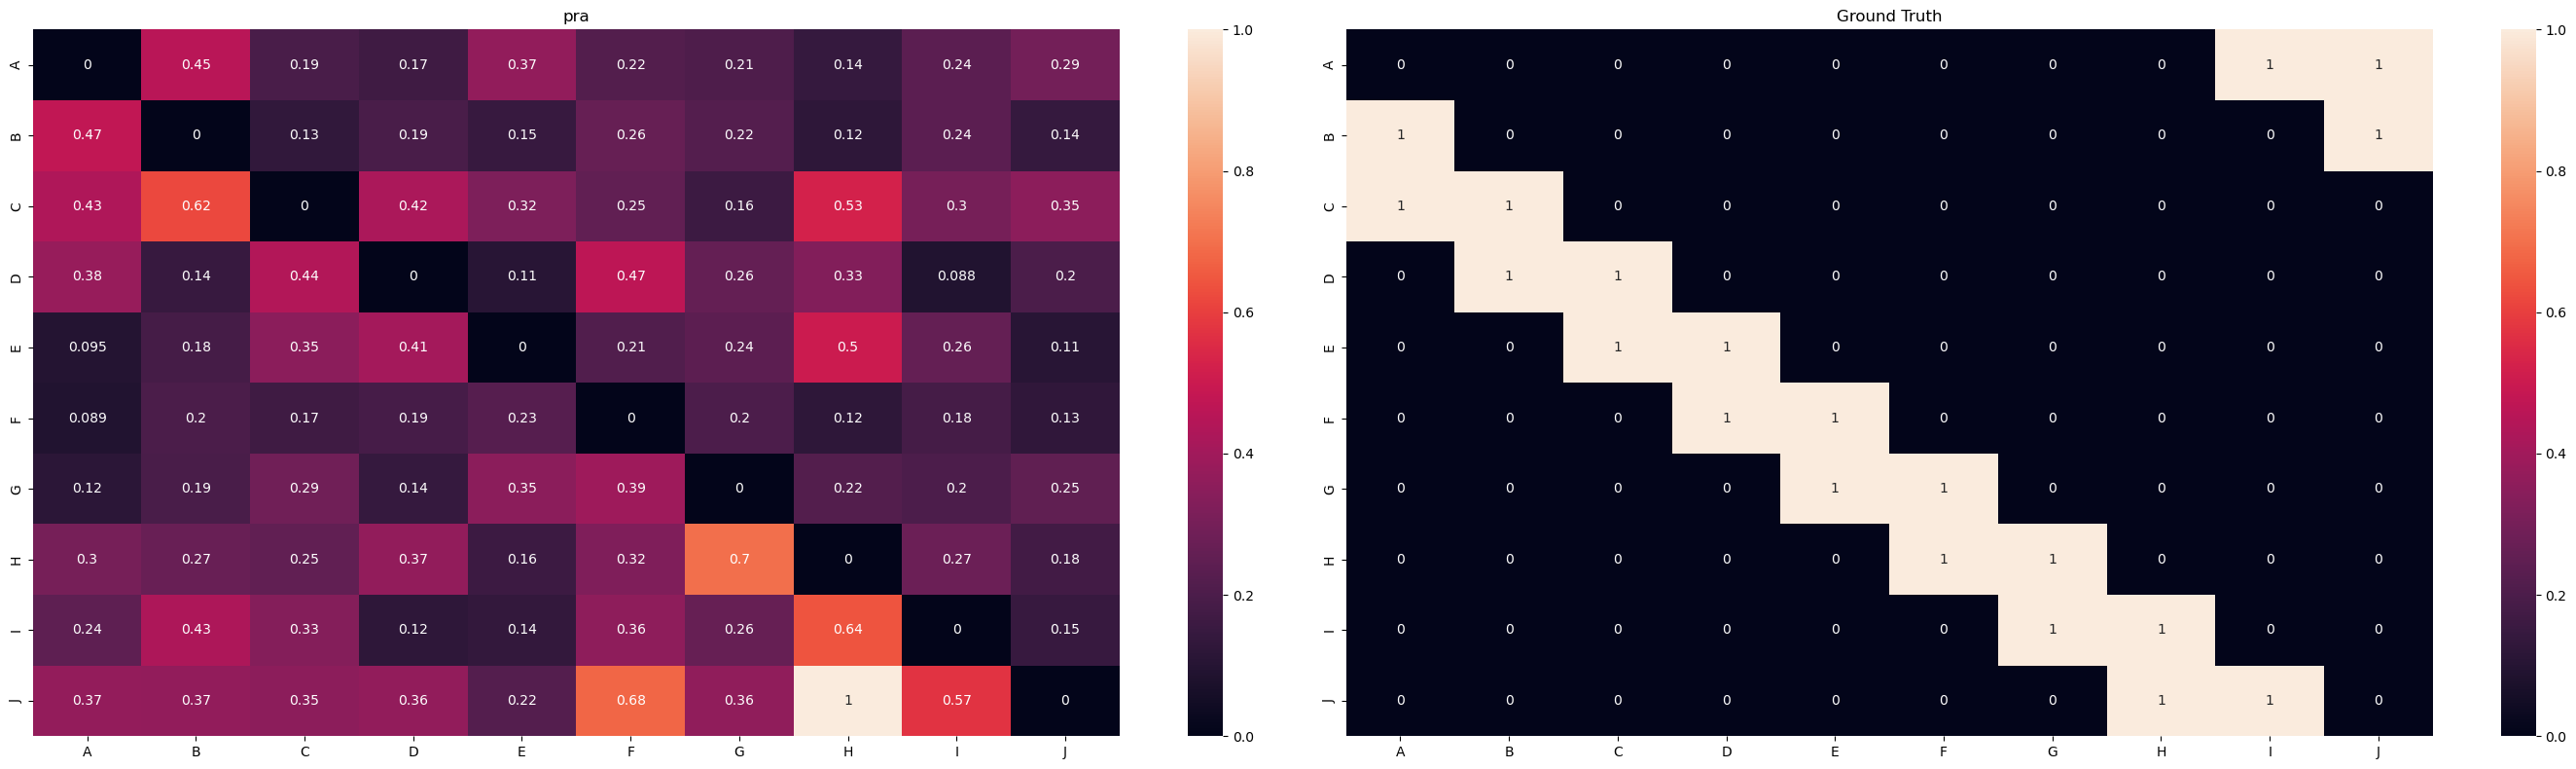

In [6]:
# Create the ground truth connectivity matrix as a NumPy array
ground_truth = np.array([
    [0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
]).T

labels = ['A','B','C','D','E','F','G','H','I','J']

fig, (ax2,ax3) = plt.subplots(1,2,figsize=(28,8))
#sns.heatmap(dynsys_mat.squeeze(), annot=True, xticklabels=['A','B','C','D','E','F','G','H','I','J'], yticklabels=['A','B','C','D','E','F','G','H','I','J'], ax=ax1)
#ax1.set_title('dynsys')

sns.heatmap(pra_mat, annot=True, xticklabels=['A','B','C','D','E','F','G','H','I','J'], yticklabels=['A','B','C','D','E','F','G','H','I','J'], ax=ax2)
ax2.set_title('pra')

# Plotting the ground truth connectivity matrix
#plt.figure(figsize=(10, 8))
sns.heatmap(adjacency_matrix, annot=True, xticklabels=['A','B','C','D','E','F','G','H','I','J'], yticklabels=['A','B','C','D','E','F','G','H','I','J'], ax=ax3)
ax3.set_title('Ground Truth')

fig.tight_layout()
plt.show()


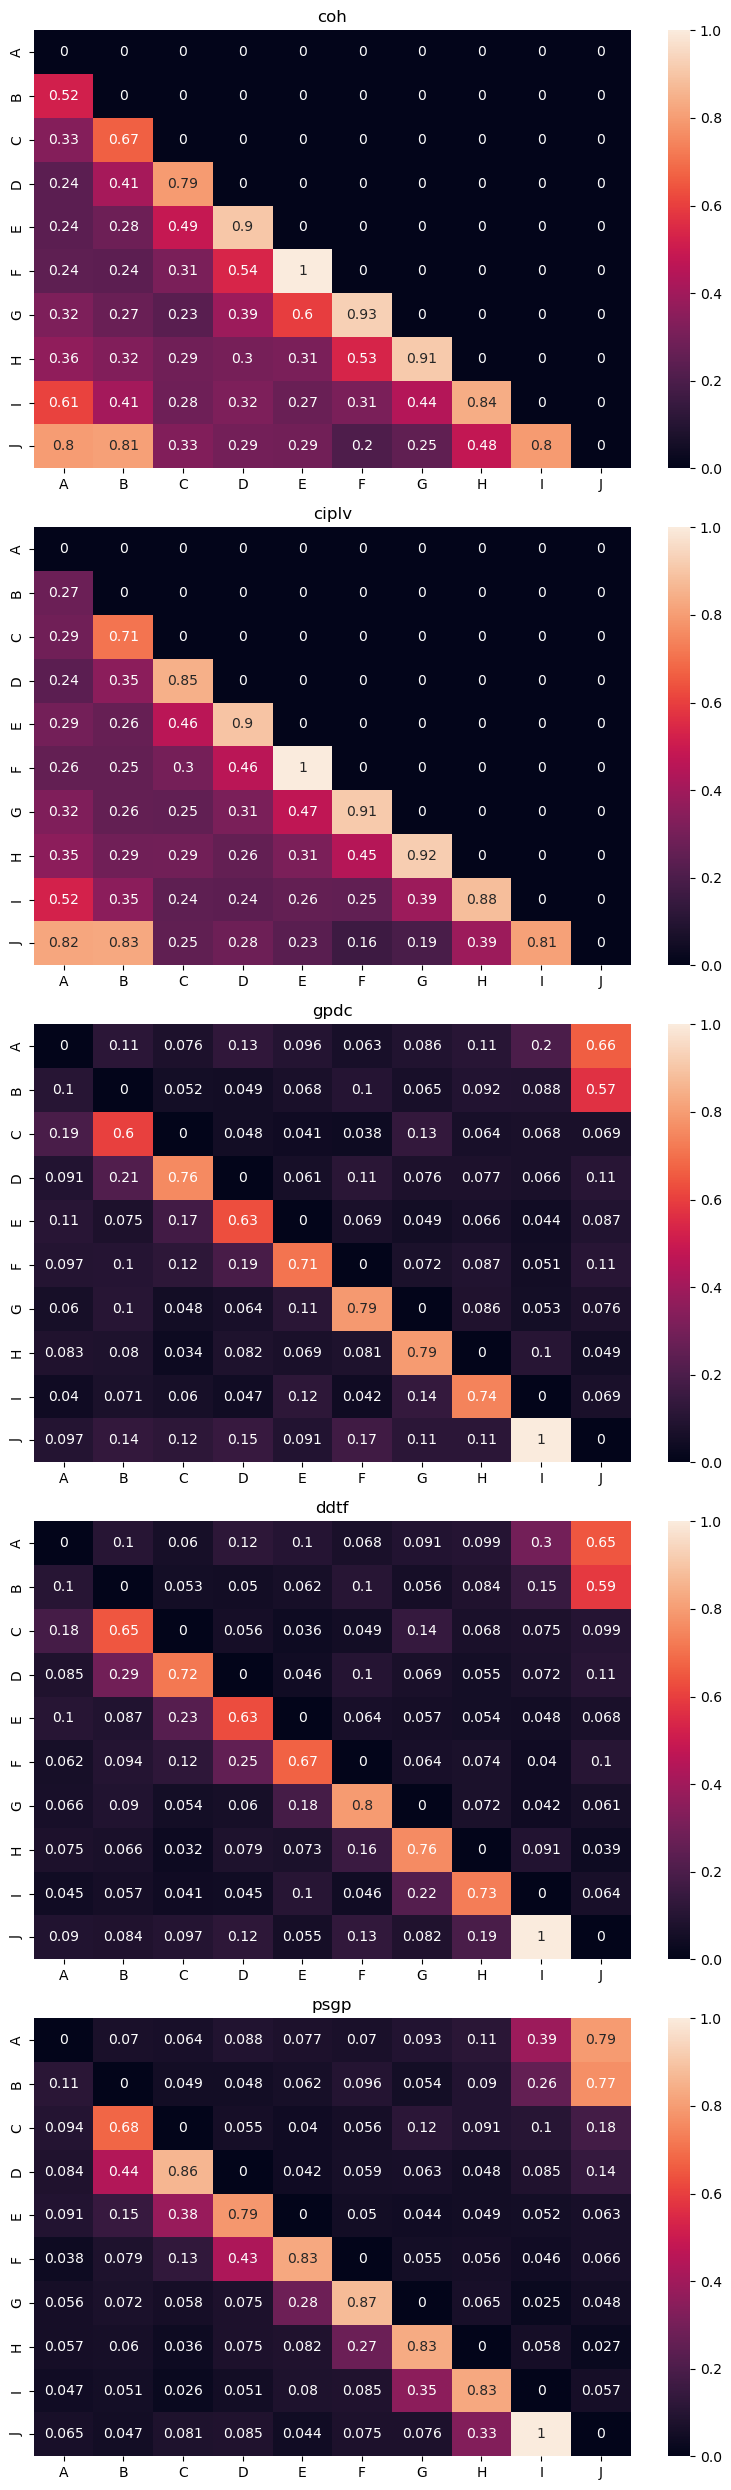

In [7]:
#Zero out the diagonal of each matrix, then min max normalize it
coh_mat = coh_mat.mean(2)
ciplv_mat = ciplv_mat.mean(2)
gpdc_mat = gpdc_mat.mean(2)
ddtf_mat = ddtf_mat.mean(2)
psgp_mat = psgp_mat.mean(2)
np.fill_diagonal(coh_mat,0)
np.fill_diagonal(ciplv_mat,0)
np.fill_diagonal(gpdc_mat,0)
np.fill_diagonal(ddtf_mat,0)
np.fill_diagonal(psgp_mat,0)

coh_mat = (coh_mat - np.min(coh_mat)) / (np.max(coh_mat) - np.min(coh_mat))
ciplv_mat = (ciplv_mat - np.min(ciplv_mat)) / (np.max(ciplv_mat) - np.min(ciplv_mat))
gpdc_mat = (gpdc_mat - np.min(gpdc_mat)) / (np.max(gpdc_mat) - np.min(gpdc_mat))
ddtf_mat = (ddtf_mat - np.min(ddtf_mat)) / (np.max(ddtf_mat) - np.min(ddtf_mat))
psgp_mat = (psgp_mat - np.min(psgp_mat)) / (np.max(psgp_mat) - np.min(psgp_mat))


fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(5,1,figsize=(8,25))
sns.heatmap(coh_mat, annot=True, xticklabels=labels, yticklabels=labels, ax=ax1)
ax1.set_title('coh')

sns.heatmap(ciplv_mat, annot=True, xticklabels=labels, yticklabels=labels, ax=ax2)
ax2.set_title('ciplv')

sns.heatmap(gpdc_mat, annot=True, xticklabels=labels, yticklabels=labels, ax=ax3)
ax3.set_title('gpdc')

sns.heatmap(ddtf_mat, annot=True, xticklabels=labels, yticklabels=labels, ax=ax4)
ax4.set_title('ddtf')

sns.heatmap(psgp_mat, annot=True, xticklabels=labels, yticklabels=labels, ax=ax5)
ax5.set_title('psgp')
fig.tight_layout()
plt.show()

In [8]:
#Get lower triangular part of adjacency matrix
adjacency_matrix_lower = np.tril(adjacency_matrix, k=-1)
coh_mat = np.tril(coh_mat, k=-1)
ciplv_mat = np.tril(ciplv_mat, k=-1)

#Calculating the MSE between the estimated and ground truth connectivity matrices
mse_dynsys = np.mean((dynsys_mat.squeeze() - adjacency_matrix) ** 2)
mse_pra = np.mean((pra_mat - adjacency_matrix) ** 2)
mse_coh = np.mean((coh_mat - adjacency_matrix_lower) ** 2)
mse_ciplv = np.mean((ciplv_mat - adjacency_matrix_lower) ** 2)
mse_gpdc = np.mean((gpdc_mat - adjacency_matrix) ** 2)
mse_ddtf = np.mean((ddtf_mat - adjacency_matrix) ** 2)
mse_psgp = np.mean((psgp_mat - adjacency_matrix) ** 2)
print(f'MSE dynsys: {mse_dynsys}')
print(f'MSE pra: {mse_pra}')
print(f'MSE coh: {mse_coh}')
print(f'MSE ciplv: {mse_ciplv}')
print(f'MSE gpdc: {mse_gpdc}')
print(f'MSE ddtf: {mse_ddtf}')
print(f'MSE psgp: {mse_psgp}')


MSE dynsys: 0.20767826014088248
MSE pra: 0.13228622284402522
MSE coh: 0.0656244333033829
MSE ciplv: 0.07037576599327294
MSE gpdc: 0.0862986966259206
MSE ddtf: 0.07641318064991649
MSE psgp: 0.05738056646776285
